In [1]:
import sys
import math
import itertools
from pathlib import Path
from datetime import datetime
from typing import Any, Callable, Dict, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path to find data_handling.py
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        # Matches your old init_std=0.01
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    # --- Augmented Gibbs Helpers ---
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        return (term1_v - term2_v), (term1_f - term2_f)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        return s0 * v + (1.0 - s0) * (1.0 - v)

    def _gibbs_step_sym_fast(self, v, h, s0, b_mod, c_mod, rng):
        # 1. Sample h | v, s
        v_eff = self._apply_flip(v, s0)
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)

        # 2. Sample s | v, h (using reused a=Wh)
        a = h @ self.W.t()
        vb   = (v * b_mod).sum(dim=-1)
        va   = (v * a).sum(dim=-1)
        bsum = b_mod.sum(dim=-1)
        asum = a.sum(dim=-1)
        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_s0 = torch.sigmoid(dE / self.T)
        s0 = torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

        # 3. Sample v | h, s
        p_v = torch.sigmoid((a + b_mod) / self.T)
        v_eff = torch.bernoulli(p_v, generator=rng)
        v_next = self._apply_flip(v_eff, s0)

        return v_next, h, s0

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        # Factor 0.5 because log(Psi) = 0.5 * log(Prob)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)
        v_model = v_data.clone()

        # Hard noise replacement (New logic) but using Configurable fraction
        noise_frac = aux_vars.get("noise_frac", 0.0)
        if noise_frac > 0:
            n_noise = int(v_data.shape[0] * noise_frac)
            if n_noise > 0:
                v_model[:n_noise] = torch.bernoulli(
                    torch.full_like(v_model[:n_noise], 0.5),
                    generator=rng
                )

        B = v_model.size(0)
        s0 = torch.ones((B, 1), device=v_model.device, dtype=v_model.dtype) # Start in 'no flip' state
        h = torch.zeros((B, self.num_hidden), device=v_model.device, dtype=v_model.dtype)

        for _ in range(self.k):
            v_model, h, s0 = self._gibbs_step_sym_fast(v_model, h, s0, b_mod, c_mod, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = fe_data.mean() - fe_model.mean()
        return loss, {}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.unsqueeze(0)
        cond_exp = cond.expand(all_states.shape[0], -1)

        # We ensure T=1 for evaluation consistency
        old_T = self.T
        self.T = 1.0
        log_psi = self.log_score(all_states, cond_exp)
        self.T = old_T

        log_norm_sq = torch.logsumexp(2.0 * log_psi, dim=0)
        return torch.exp(log_psi - 0.5 * log_norm_sq)

In [3]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train_loop(model, optimizer, loader, num_epochs, rng, lr_schedule_fn, noise_frac):
    global_step = 0
    model.train()

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 35)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    if not gt_path.exists(): return 0.0
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true)
    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)
    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [5]:
# --- EXPERIMENT CONFIG ---
SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000   # Your old setting
FILE_SUFFIX = "20000"

# Exact values from your 1D Chain Data
h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]
h_novel   = [0.60, 0.70, 1.30, 1.40]

# --- Hyperparameters (OLD) ---
HIDDEN_UNITS = 64        # Old: 80
COND_WIDTH = 64
CD_K = 20               # Old: 15
LR_INIT = 1e-2           # Old: 0.03
LR_FINAL = 1e-4
N_EPOCHS = 50
BATCH_SIZE = 1024
NOISE_FRAC = 0.1        # Old: 0.02

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

# Construct paths (1D Chain)
file_paths = []
print("Loading Training Data (1D Chain L=16)...")
for h in h_support:
    fname = f"tfim_{SYSTEM_SIZE}_h{h:.2f}_{FILE_SUFFIX}.npz"
    fpath = data_dir / fname
    if fpath.exists():
        file_paths.append(fpath)
    else:
        print(f"  ! MISSING: {fname}")

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLES] * len(file_paths))
loader = MeasurementLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

# Initialize NEW Model Architecture
model = ConditionalRBM(
    num_visible=SYSTEM_SIZE,
    num_hidden=HIDDEN_UNITS,
    cond_dim=1,
    conditioner_width=COND_WIDTH,
    k=CD_K,
    T=1.0 # Standard T
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)
schedule_steps = N_EPOCHS * len(loader)
scheduler = get_sigmoid_curve(LR_INIT, LR_FINAL, schedule_steps, falloff=0.002)

print(f"Training Symmetric (Augmented) CRBM on L={SYSTEM_SIZE}...")
model = train_loop(model, optimizer, loader, N_EPOCHS, rng, scheduler, NOISE_FRAC)
print("Training Complete.")

Loading Training Data (1D Chain L=16)...
Training Symmetric (Augmented) CRBM on L=16...
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0504     | 0.009986
10     | -0.0035     | 0.009840
20     | +0.0075     | 0.007997
30     | -0.0058     | 0.002109
40     | -0.0041     | 0.000260
50     | -0.0029     | 0.000110
Training Complete.


Generating full Hilbert space for exact evaluation...
h      | Type       | Overlap   
-----------------------------------
0.50   | Support    | 0.99973
0.60   | Novel      | 0.99953
0.70   | Novel      | 0.99929
0.80   | Support    | 0.99905
0.95   | Support    | 0.99846
1.00   | Support    | 0.99820
1.05   | Support    | 0.99804
1.20   | Support    | 0.99844
1.30   | Novel      | 0.99835
1.40   | Novel      | 0.99839
1.50   | Support    | 0.99828


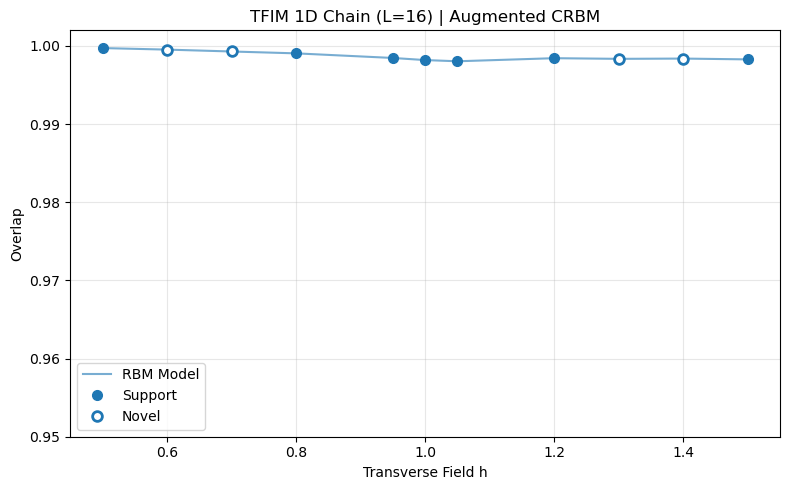

In [6]:
print("Generating full Hilbert space for exact evaluation...")
all_states = generate_all_states(SYSTEM_SIZE, device)
all_eval_h = sorted(list(set(h_support + h_novel)))

results = []
print(f"{'h':<6} | {'Type':<10} | {'Overlap':<10}")
print("-" * 35)

for h_val in all_eval_h:
    gt_fname = f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
    gt_path = state_dir / gt_fname

    if not gt_path.exists():
        continue

    overlap = compute_overlap(model, h_val, gt_path, all_states)
    is_supp = any(np.isclose(h_val, s, atol=1e-5) for s in h_support)
    pt_type = "Support" if is_supp else "Novel"

    results.append({"h": h_val, "overlap": overlap, "type": pt_type})
    print(f"{h_val:<6.2f} | {pt_type:<10} | {overlap:.5f}")

df_res = pd.DataFrame(results)

# Plot
plt.figure(figsize=(8, 5), dpi=100)
supp = df_res[df_res["type"] == "Support"]
nov  = df_res[df_res["type"] == "Novel"]
plt.plot(df_res["h"], df_res["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")
plt.xlabel("Transverse Field h")
plt.ylabel("Overlap")
plt.title(f"TFIM 1D Chain (L={SYSTEM_SIZE}) | Augmented CRBM")
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Adjusted filename to reflect L=16 1D chain
filename = f"crbm_tfim_16_{TRAIN_SAMPLES}_entropy_{timestamp}.pt"
save_path = models_dir / filename

save_dict = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "config": {
        "num_visible": model.num_visible,
        "num_hidden": model.num_hidden,
        "k_steps": model.k,
        "train_samples": TRAIN_SAMPLES,
        "epochs": N_EPOCHS,
        "h_support": h_support,
        "h_novel": h_novel, # Added for completeness
        "lr_init": LR_INIT
    },
    "results": results
}

torch.save(save_dict, save_path)
print(f"Model saved successfully to:\n{save_path.resolve()}")

Model saved successfully to:
/Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_16/models/crbm_tfim_16_20000_entropy_20260113_172434.pt
